In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time
import seaborn as sns


# Assignement 

# Aiyagari-Bewley-Huggett-Imrohoglu Model Simulation

## Objective
The goal of this project is to solve and simulate a finite horizon model known as the "Aiyagari-Bewley-Huggett-Imrohoglu" model. Your task involves coding the solution and simulation of this model, followed by a thorough documentation of the methodology employed.

## Household Optimization Problem
The households seek to maximize their utility over a finite time horizon, as represented by the following objective function:

$$
\max_{c_t, a_{t+1}} E \left( \sum_{t=1}^{T} \beta^t \ln(c_t) \right)
$$

subject to the budget constraint:

$$
c_t + a_{t+1} = (1 + r) a_t + y_t
$$

$$
a_t \geq a
$$

where log-income $\ln y$ follows an autoregressive process:

$$
\ln(y_{t+1}) = \rho \ln(y_t) + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)
$$




## Parameters
- Interest rate \( r = 5\% \)
- Time discount factor \( \beta = 0.95 \)
- Time horizon \( T = 40 \)
- Minimum asset level \( a \) taking values in the set \{−40, −10, 0\}
- Autoregressive coefficient \( \rho = 0.90 \)
- Standard deviation of income shocks \( \sigma = 0.1 \)
- Initial conditions \( y_1 = 1, a_1 = 0 \)
- Terminal condition \( a_{T+1} = 0 \)

## Tasks
1. **Code the Solution and Simulation**: Implement the model solution and simulation in either Python or Julia.





## My SOlution (EMile)

 We start by discretizing the AR(1) process for income using Tauchen's method, which approximates a continuous AR(1) process with a finite state Markov chain. This gives us a discrete grid of income states $\{ y_j \}$ and a transition matrix $P$, where $P(y' \mid y_j)$ denotes the probability of transitioning from income state $y_j$ to $y'$.

The agent's objective is to maximize the expected discounted sum of utilities over the finite horizon, which can be formulated using the Bellman equation. For period $t$, the agent's value function $v_t(a_i, y_j)$ represents the maximum expected utility achievable from state $(a_i, y_j)$.

The Bellman equation for the agent's problem is:
$$
v_t(a_i, y_j) = \max_{c, a'} \left\{ u(c) + \beta \sum_{y'} v_{t+1}(a', y') P(y' \mid y_j) \right\}
$$
subject to the budget constraint:
$$
c = R \cdot a_i + y_j - a'
$$

where:

- $c$ is consumption,
- $a_i$ is the current level of assets,
- $y_j$ is the current income state,
- $a'$ is next period's asset level,
- $u(\cdot)$ is the utility function,
- $\beta$ is the discount factor,
- $R$ is the return factor on savings.


This formulation captures the agent's decision-making process under uncertainty regarding income shocks and optimization over asset accumulation and consumption choices.

This dynamic programming problem can be solved by various methods. It is a \textbf{finite} horizon problem, so a simple backward induction is used.


The  method simulates the model based on the computed policy:

\begin{align*}
    & a_{t+1}(i) = a^*_t(a_t(i), y_t(i)) \\
    & y_{t+1}(i) \sim P(y' | y_t(i))\\
    & c_t = (1+r) a_t + y_t - a_{t+1} 
\end{align*}

where $a^*$ is the policy function derived from backward induction, and $y_t(i)$ denotes the income state of agent $i$ at time $t$. We simulate the model for 100,000 agents.

In [2]:

class LifecycleModel:
    def __init__(self, a_bar=10, beta=0.95, T=40, R=1.05, a_min=0, a_size=100, rho=0.9, sigma=0.1, y_size=50,num_agents=1000):
        self.a_bar = a_bar
        self.beta = beta
        self.T = T
        self.R = R
        self.a_min = a_min 
        self.a_size = a_size
        self.rho = rho
        self.sigma = sigma
        self.y_size = y_size
        self.a_grid = np.linspace(a_min,a_bar, a_size)
        self.y_grid, self.P = self.tauchen(y_size=y_size, rho=rho, sigma=sigma, m=3)
        self.num_agents = num_agents
        
    def tauchen(self, rho, sigma, y_size, m=3):
        n = y_size
        z_max = m * sigma / np.sqrt(1 - rho**2)
        z_min = -z_max
        z = np.linspace(z_min, z_max, n)
        step = (z_max - z_min) / (n - 1)
        Pi = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if j == 0:
                    Pi[i, j] = norm.cdf((z[0] - rho * z[i] + step / 2) / sigma)
                elif j == n - 1:
                    Pi[i, j] = 1 - norm.cdf((z[-1] - rho * z[i] - step / 2) / sigma)
                else:
                    Pi[i, j] = (norm.cdf((z[j] - rho * z[i] + step / 2) / sigma) - 
                                norm.cdf((z[j] - rho * z[i] - step / 2) / sigma))
        y_grid = np.exp(z)
        return y_grid, Pi
    

    
    def backward_induction(self):
        v = np.zeros((self.T + 1, self.a_size, self.y_size))
        policy = np.zeros((self.T, self.a_size, self.y_size), dtype=int)

        # Initialize terminal value function: all assets are consumed
        for j in range(self.y_size):
            for i in range(self.a_size):
                consumption = self.R * self.a_grid[i] + self.y_grid[j]
                v[self.T, i, j] = np.log(consumption)

        # Perform backward induction
        for t in range(self.T - 1, -1, -1):
            for i in range(self.a_size):
                for j in range(self.y_size):
                    c = self.R * self.a_grid[i] + self.y_grid[j] - self.a_grid
                    EV = np.dot(v[t + 1, :, :], self.P[j])
                    rhs = np.where(c > 0, np.log(c) + self.beta * EV, -np.inf)
                    v[t, i, j] = np.max(rhs)
                    policy[t, i, j] = np.argmax(rhs)

        return v, policy

    def simulate_lifecycle(self, policy, num_agents):
        a_star = np.empty((self.T, self.a_size, self.y_size))
        for t in range(self.T):
            for a_i in range(self.a_size):
                for y_i in range(self.y_size):
                    a_star[t, a_i, y_i] = self.a_grid[policy[t, a_i, y_i]]

        a = np.zeros((self.T, num_agents))
        c = np.zeros((self.T, num_agents))
        y = np.zeros((self.T, num_agents))

        y[0, :] = 1  # Initial income state
        a[0, :] = 0  # Initial asset state

        for i in range(num_agents):
            for t in range(self.T - 1):
                a_val = a[t, i]
                y_val = y[t, i]

                a_idx = np.argmin(np.abs(self.a_grid - a_val))
                y_idx = np.argmin(np.abs(self.y_grid - y_val))
                a[t + 1, i] = a_star[t, a_idx, y_idx]

                c[t, i] = y_val + self.R * a_val - a[t + 1, i]
                y_idx = np.random.choice(self.y_size, p=self.P[y_idx])
                y[t + 1, i] = self.y_grid[y_idx]

        # Final period consumption
        c[-1, :] = y[-1, :] + self.R * a[-1, :]  # consume all remaining assets

        return a, c, y



    def plot_distribution(self, data_list, low_threshold, high_threshold, title, y_label, labels, a_bar_values, filename_prefix):
        for k, (data, a_bar) in enumerate(zip(data_list, a_bar_values)):
            low_tier_proportion = np.zeros(self.T)
            mid_tier_proportion = np.zeros(self.T)
            high_tier_proportion = np.zeros(self.T)
            
            for t in range(self.T):
                values = data[t]
                low_tier_proportion[t] = np.mean(values <= low_threshold)
                mid_tier_proportion[t] = np.mean((values > low_threshold) & (values <= high_threshold))
                high_tier_proportion[t] = np.mean(values > high_threshold)
            
            plt.bar(range(self.T), low_tier_proportion, label=labels[0], width=0.8)
            plt.bar(range(self.T), mid_tier_proportion, bottom=low_tier_proportion, label=labels[1], width=0.8)
            plt.bar(range(self.T), high_tier_proportion, bottom=low_tier_proportion + mid_tier_proportion, label=labels[2], width=0.8)
            
            plt.xlabel('Time Period')
            plt.ylabel(y_label)
            plt.title(f'{title} (a_bar={a_bar})')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'{filename_prefix}_a_bar_{a_bar}.eps', format='eps')
            plt.show()

    def plot_mean_std(self, data_dict):
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        
        for key in data_dict:
            a, c, y = data_dict[key]
            axs[0, 0].plot(np.mean(a, axis=1)[:-1], label=f'a_bar={key}')
            axs[0, 1].plot(np.mean(c, axis=1)[:-1], label=f'a_bar={key}')
            axs[0, 2].plot(np.mean(y, axis=1)[:-1], label=f'a_bar={key}')
            axs[1, 0].plot(np.std(a, axis=1)[1:-1], label=f'a_bar={key}')
            axs[1, 1].plot(np.std(c, axis=1)[1:-1], label=f'a_bar={key}')
            axs[1, 2].plot(np.std(y, axis=1)[1:-1], label=f'a_bar={key}')
        
        axs[0, 0].set_title('Mean of $a_t$')
        axs[0, 1].set_title('Mean of $c_t$ ')
        axs[0, 2].set_title('Mean of $y_t$ ')
        axs[1, 0].set_title('Std of $a_t$ ')
        axs[1, 1].set_title('Std of $c_t$ ')
        axs[1, 2].set_title('Std of $y_t$ ')
        
        for ax in axs.flat:
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.savefig('mean_std.eps', format='eps')
        plt.show()
        
    def plot_density(self, results):
        fig, axs = plt.subplots(3, 3, figsize=(12, 6))

        time_points = [5, 15, 35]
        colors = ['r', 'g', 'b']
        labels = [f'Time {t}' for t in time_points]

        for idx, (a_min, (a, c, y)) in enumerate(results.items()):
            for t, color, label in zip(time_points, colors, labels):
                sns.kdeplot(a[t, :], ax=axs[0, idx], color=color, label=label)
                sns.kdeplot(c[t, :], ax=axs[1, idx], color=color, label=label)
                sns.kdeplot(y[t, :], ax=axs[2, idx], color=color, label=label)
            
            axs[0, idx].set_title(f'Density of Assets (a_bar={a_min})')
            axs[1, idx].set_title(f'Density of Consumption (a_bar={a_min})')
            axs[2, idx].set_title(f'Density of Income (a_bar={a_min})')

            for ax in axs[:, idx]:
                ax.set_xlabel('')
                ax.set_ylabel('Density')
                ax.legend()
                ax.grid(True)

        plt.tight_layout()
        plt.savefig('density.eps', format='eps')
        plt.show()



C:\Users\emile\AppData\Local\Temp\ipykernel_16504\609362674.py:53: RuntimeWarning: invalid value encountered in log
  rhs = np.where(c > 0, np.log(c) + self.beta * EV, -np.inf)


Calculation completed in 6.84 minutes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


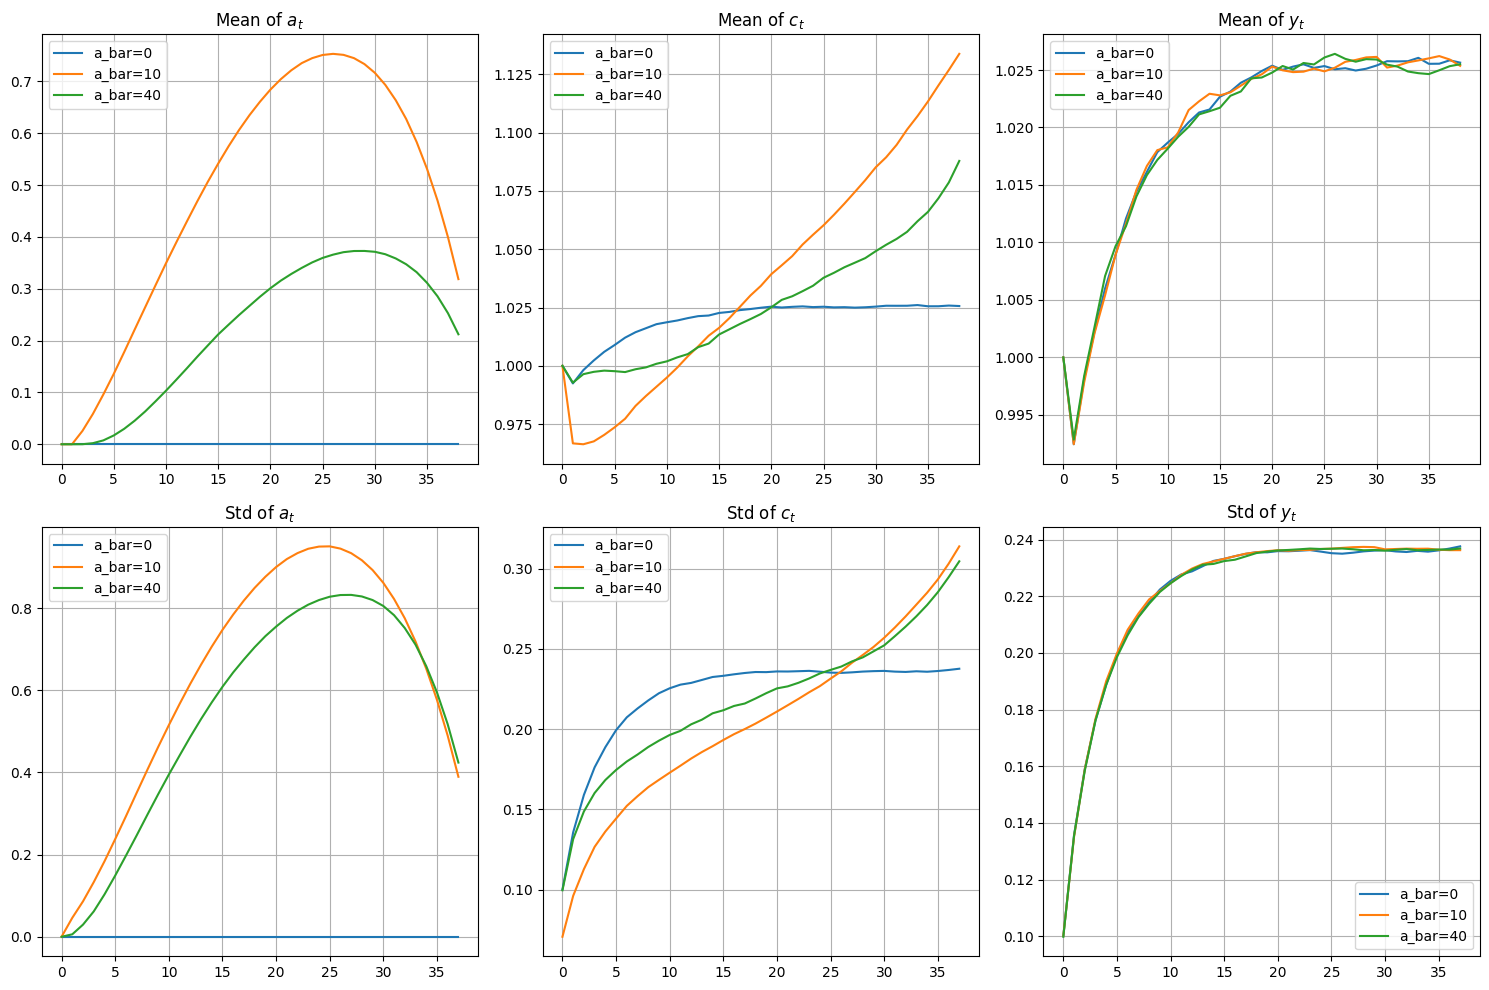

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


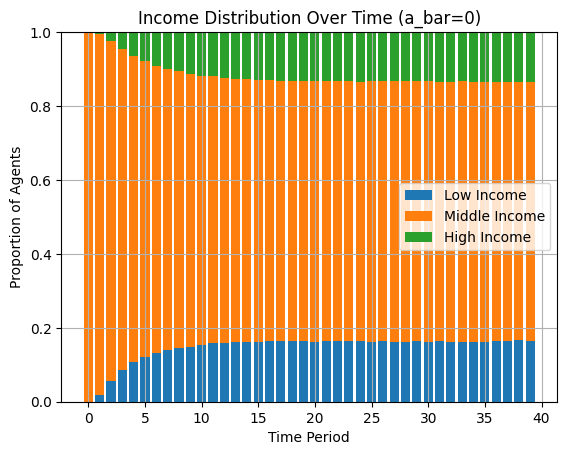

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


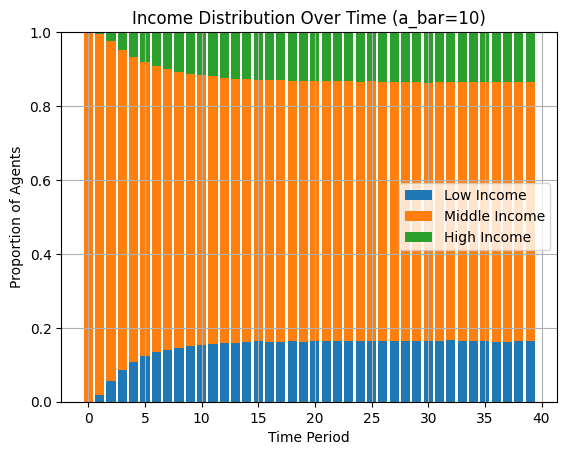

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


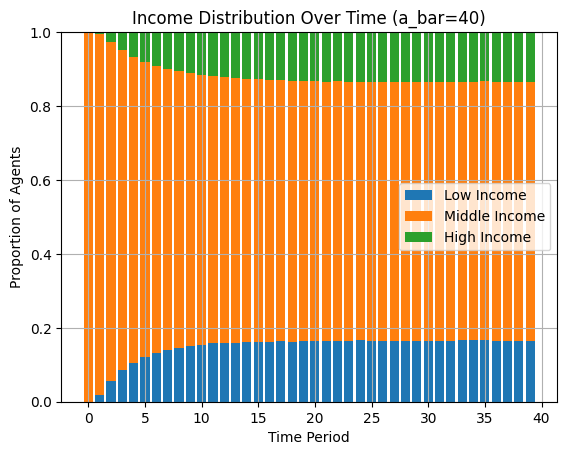

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


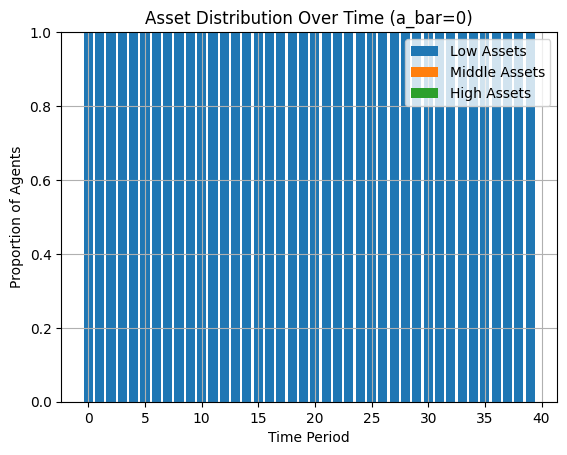

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


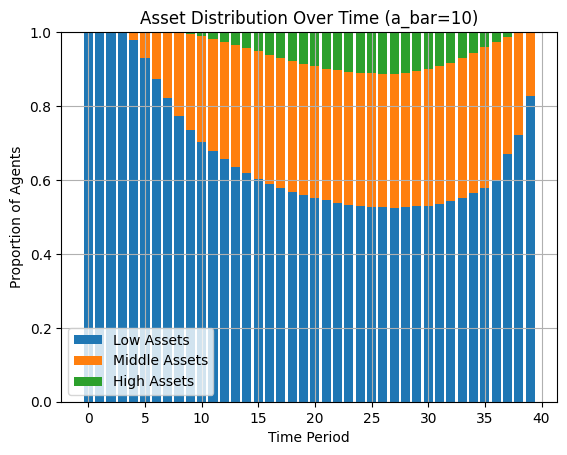

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


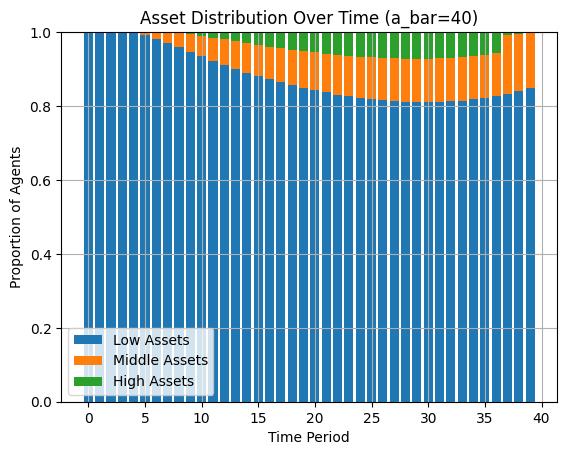

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


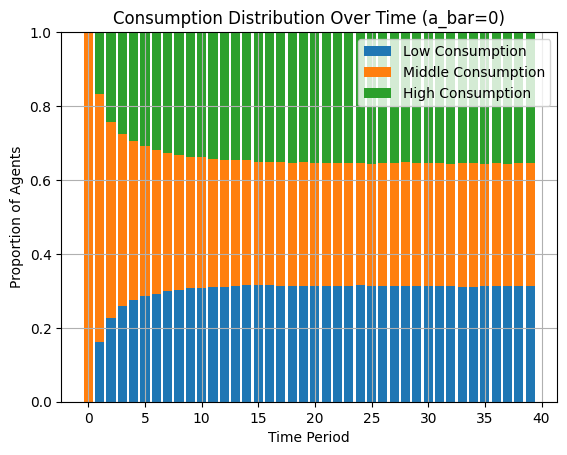

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


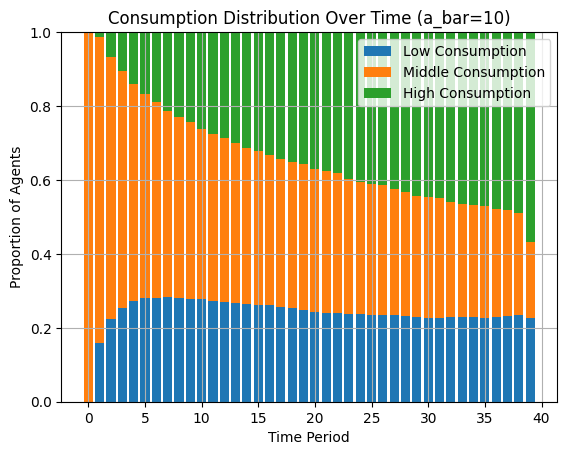

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


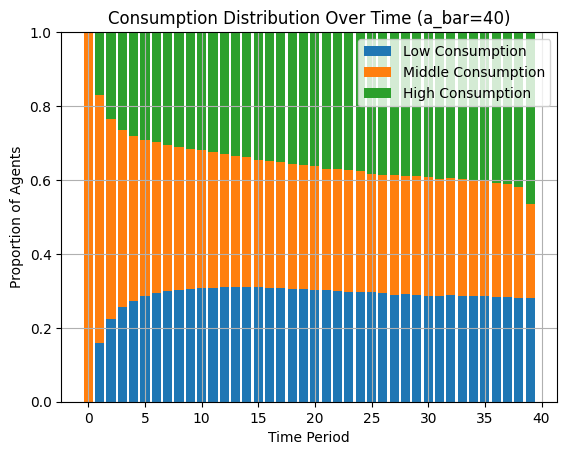

C:\Users\emile\AppData\Local\Temp\ipykernel_16504\609362674.py:153: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(a[t, :], ax=axs[0, idx], color=color, label=label)
C:\Users\emile\AppData\Local\Temp\ipykernel_16504\609362674.py:153: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(a[t, :], ax=axs[0, idx], color=color, label=label)
C:\Users\emile\AppData\Local\Temp\ipykernel_16504\609362674.py:153: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(a[t, :], ax=axs[0, idx], color=color, label=label)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rend

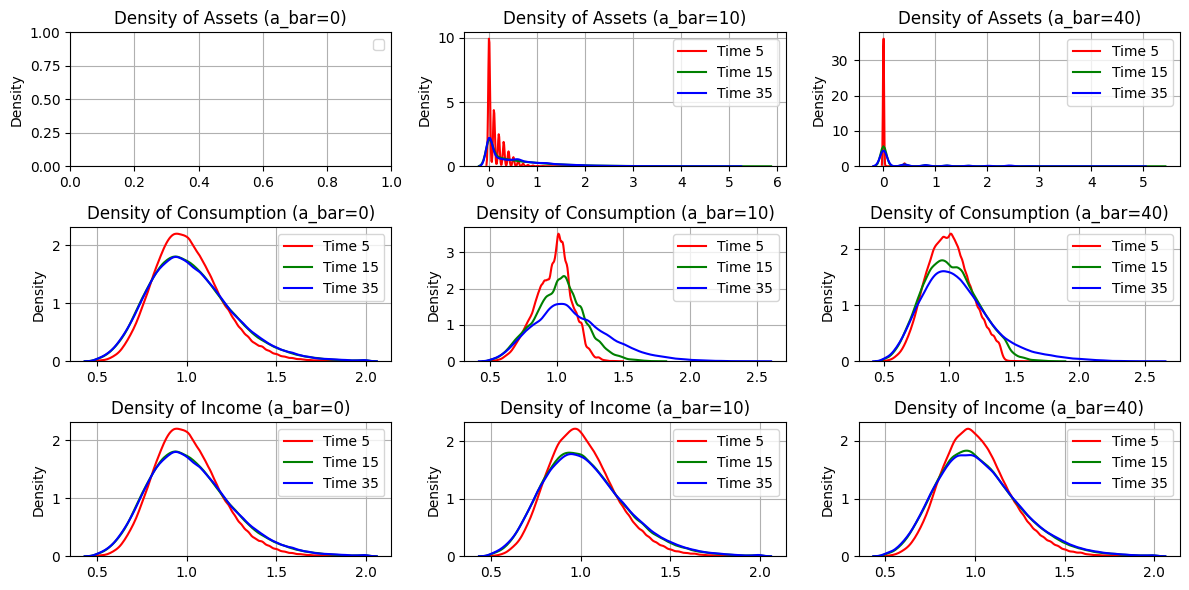

In [3]:

if __name__ == "__main__":
    start = time()
    a_bar_values = [0, 10, 40]
    data_dict = {}

    for a_bar in a_bar_values:
        model = LifecycleModel(a_bar=a_bar)
    
        v_star, policy = model.backward_induction()

        a, c, y = model.simulate_lifecycle(policy, num_agents=100000)
        data_dict[a_bar] = (a, c, y)
    
    duration = time() - start
    print(f"Calculation completed in {duration/60:.2f} minutes")

    # Plot Mean and Std
    model.plot_mean_std(data_dict)
    
    # Plot Income Distribution
    y_data_list = [data_dict[a_bar][2] for a_bar in a_bar_values]
    model.plot_distribution(y_data_list, low_threshold=model.y_grid[int(model.y_size / 3)], high_threshold=model.y_grid[int(2 * model.y_size / 3)], 
                            title='Income Distribution Over Time', y_label='Proportion of Agents', labels=['Low Income', 'Middle Income', 'High Income'], a_bar_values=a_bar_values, filename_prefix='income_distribution')
    
    # Plot Asset Distribution
    a_data_list = [data_dict[a_bar][0] for a_bar in a_bar_values]
    model.plot_distribution(a_data_list, low_threshold=0.5, high_threshold=2, 
                            title='Asset Distribution Over Time', y_label='Proportion of Agents', labels=['Low Assets', 'Middle Assets', 'High Assets'], a_bar_values=a_bar_values, filename_prefix='asset_distribution')
    
    # Plot Consumption Distribution
    c_data_list = [data_dict[a_bar][1] for a_bar in a_bar_values]
    model.plot_distribution(c_data_list, low_threshold=0.9, high_threshold=1.1, 
                            title='Consumption Distribution Over Time', y_label='Proportion of Agents', labels=['Low Consumption', 'Middle Consumption', 'High Consumption'], a_bar_values=a_bar_values, filename_prefix='consumption_distribution')


    # Plot Density
    model.plot_density(data_dict)
